### Configuracion

In [1]:
import numpy as np
import cmath
import math
import matplotlib.pyplot as plt

from skimage.draw import rectangle, line
from skimage.transform import rotate
import skimage.io as io

import os

### Ejemplo de Numeros Imaginarios

In [2]:
x = 5
y = 3

# creamos a z = x + iy
z = x + 1j * y

# imprimimos la parte Real e Imaginaria. T
print("La parte real del numero es:", z.real)
print("La parte imaginaria del numero es:", z.imag)

print()

# Numpy tambien acepta operar con numeros complejos
arregloReales = np.random.randint(size=4,low=-10, high=10)
arregloImaginarios = np.random.randint(size=4,low=-10, high=10) * 1j
arregloComplejo = arregloReales + arregloImaginarios

print("Arreglo Complejo")
print(arregloComplejo)

print("Parte Real")
print(np.real(arregloComplejo))

print("Parte Imaginaria")
print(np.imag(arregloComplejo))


La parte real del numero es: 5.0
La parte imaginaria del numero es: 3.0

Arreglo Complejo
[  9.+0.j -10.+1.j   9.-3.j  -3.+4.j]
Parte Real
[  9. -10.   9.  -3.]
Parte Imaginaria
[ 0.  1. -3.  4.]


### 1. Graficar las bases de la Transformada de Fourier de dimensión 8 en 1-D y de dimensión 8 × 8 en 2-D

C:\Users\admin\AppData\Local\Temp\ipykernel_10612\3917493941.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend()


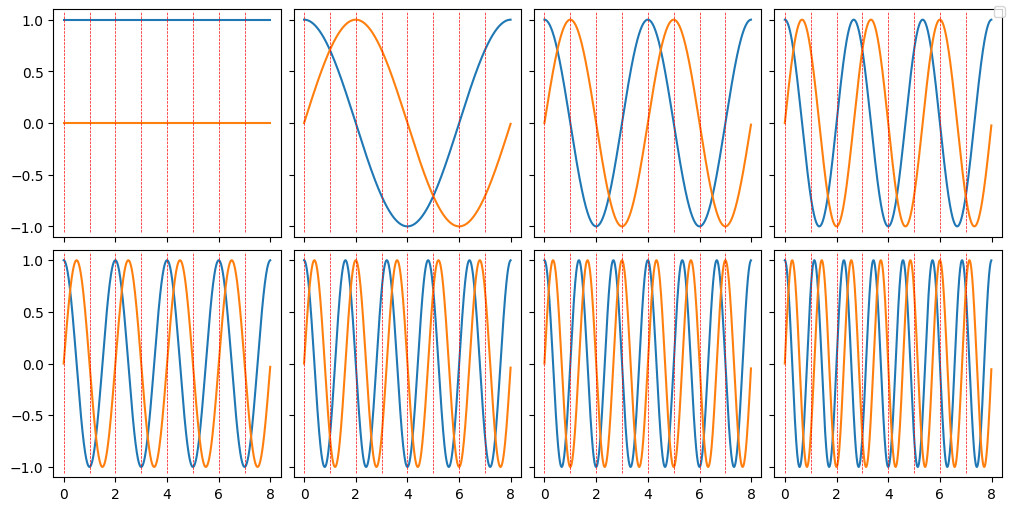

In [3]:
#Numero de Muestras de la senal
N = 8

#Opciones para graficar
#Velocidad del sampleo
sampleoRate = 1/100
#Cuantos sampleos se haran
sampleoGrafico = int(N/sampleoRate)

#Inicializamos un arreglo para guardar cada base y su evolucion
bases1D = np.zeros((N,sampleoGrafico)) * 1j

#Recorremos cada frecuencia
for frecuencia in range(0,N):
  for i in range(sampleoGrafico):
    # Por cada vemos como avanza en el tiempo para luego plotearla
    t = i*sampleoRate
    frecuenciaAngular = ((2*np.pi)/N) * (frecuencia)
    # Calculamos la parte real e imaginaria de la base.
    bases1D[frecuencia][i] = np.exp(1j * frecuenciaAngular * t)

fig, axes = plt.subplots(2,4, figsize=(10, 5),sharex=True, sharey=True, layout="constrained")
for base in range(N):
  axes[base//4][base%4].plot(np.arange(0,sampleoGrafico*sampleoRate,sampleoRate),np.real(bases1D[base]))
  axes[base//4][base%4].plot(np.arange(0,sampleoGrafico*sampleoRate,sampleoRate),np.imag(bases1D[base]))
  for sample in range(N):
    # Mostramos que valor tiene cada base al momento del sampleo de las N.
    axes[base//4][base%4].axvline(x = sample, ymin=0.02, ymax=0.99  , color = 'r', ls='--', lw=0.5)

fig.legend()


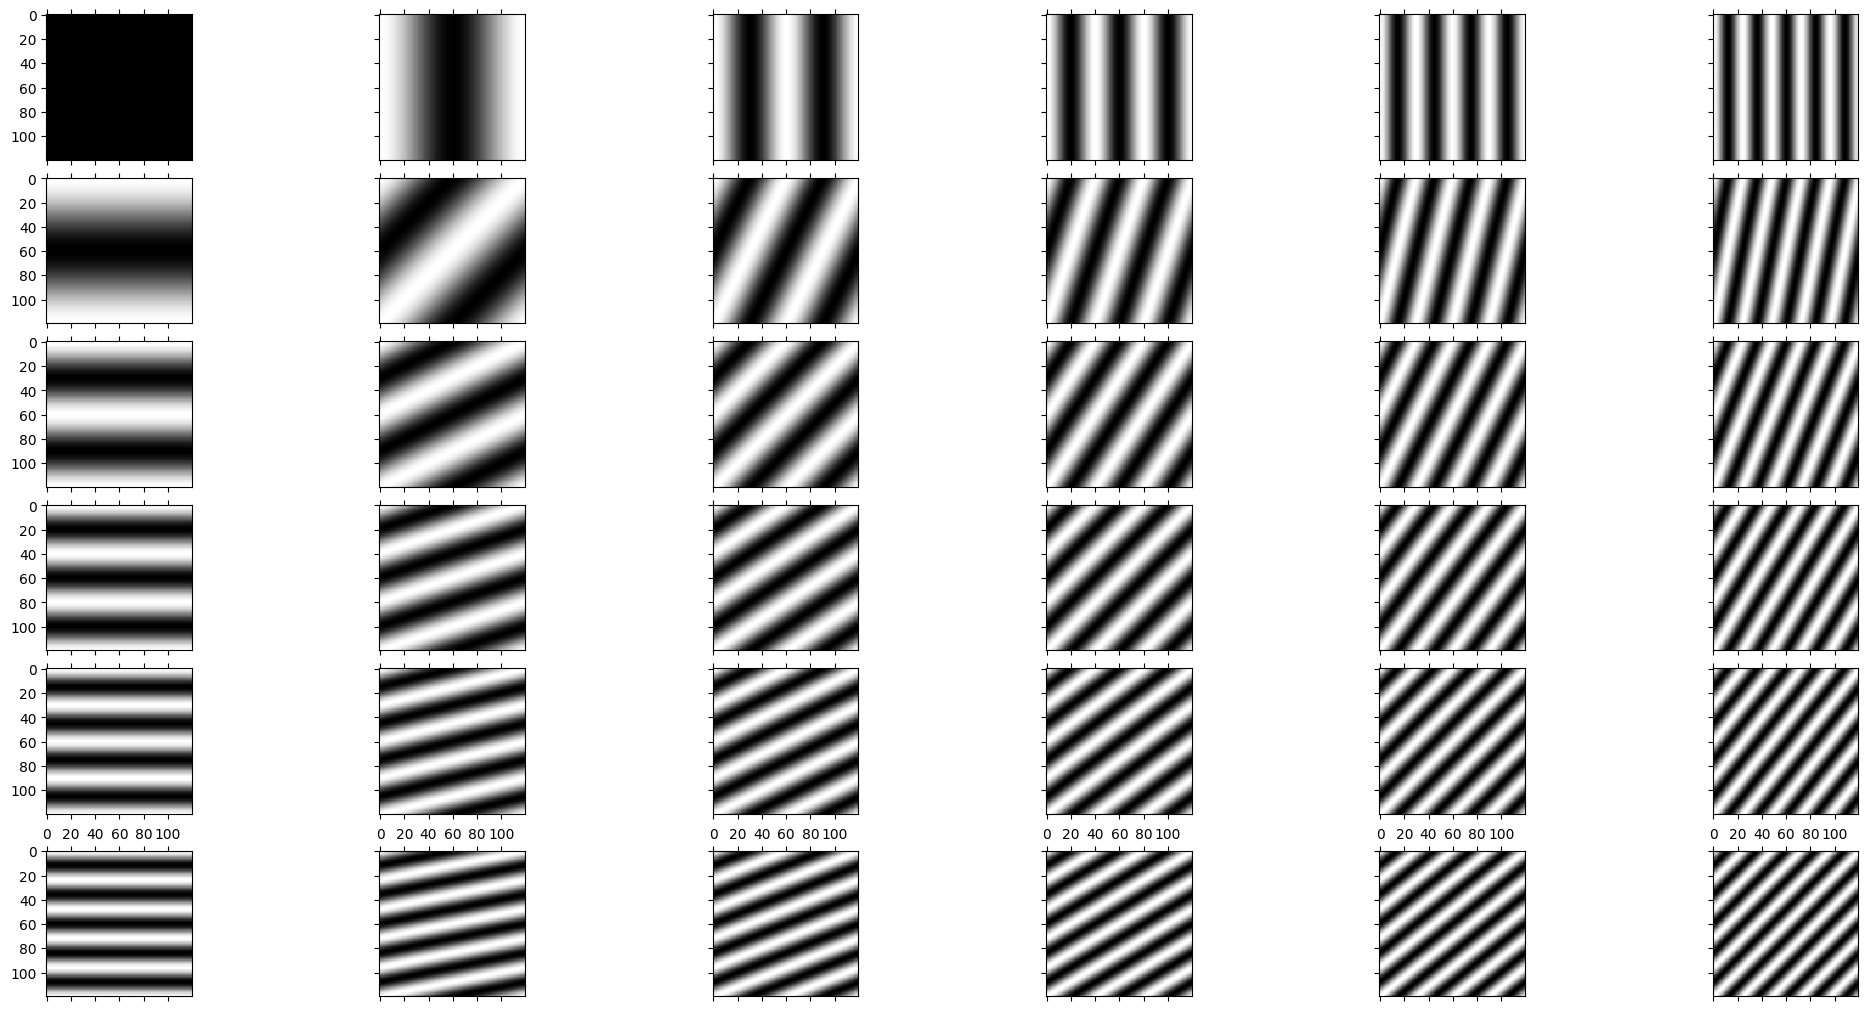

In [4]:
# Ploteo de las bases en 2D
#Definimos el sampleo horizontal y vertical
N = 6
M = 6
#Configuramos los valores para graficar
sampleoRate = 1/20
sampleoGrafico = int(N/sampleoRate)

#Ahora nuestras bases seran matrices, no arreglos
bases2D = np.zeros((N,M,sampleoGrafico,sampleoGrafico)) * 1j

for frecuenciaX in range(0,N):
  for frecuenciaY in range(0,M):
    for intervaloX in range(sampleoGrafico):
      for intervaloY in range(sampleoGrafico):
        # Calculamos como la base avanza en el tiempo y guardamos su valor
        tX = intervaloX*sampleoRate
        tY = intervaloY*sampleoRate
        frecuenciaAngularX = (2*np.pi*frecuenciaX /N)
        frecuenciaAngularY = (2*np.pi*frecuenciaY /M)
        angulo = frecuenciaAngularX * tX + frecuenciaAngularY * tY
        bases2D[frecuenciaX][frecuenciaY][intervaloX][intervaloY] = np.exp(angulo * 1j)

fig, axes = plt.subplots(N,M, figsize=(20, 10),sharex=True, sharey=True, layout="constrained")
for baseX in range(N):
  for baseY in range(M):
    axes[baseX][baseY].matshow(np.real(bases2D[baseX][baseY]),cmap=plt.cm.gray)


### Implementar la DFT en 1D

Visualizacion interactiva entre la relacion de los numeros complejos y los caminos circulares: [betterexplained.com](https://betterexplained.com/examples/fourier/)

In [67]:
"""La funcion debe devolver un arreglo con la magnitud de la frecuencia y tambien su Fase"""
def DFT_1D(senal):
  F = np.zeros(senal.size, dtype=np.complex_)
  N = senal.shape[0]
  # Realizamos el producto interno entre cada base y la senal original
  bases = np.zeros(senal.size, dtype=np.complex_)
  
  for k in range(N):
    val = 0
    for i in range(N):
      bases[i] = (np.exp(-2*np.pi*1j*(i*k)/N))
    val = np.dot(senal,bases)/np.sqrt(N)
    F[k] = val

  Fmagnitud = np.zeros(senal.size)
  Fangulo = np.zeros(senal.size)
  # Calculamas el modulo y la fase del numero complejo
  for k in range(N):
    Fmagnitud[k] = np.linalg.norm(F[k])
    Fangulo[k] = np.angle(F[k])

  
  return Fmagnitud,Fangulo

def IDFT_1D(senalModulo, senalFase):
  # Realizamos la sumatoria entre cada base y su proyeccion
  N = senalModulo.size
  f = np.zeros(senalModulo.size)
  for k in range(N):
    val = 0
    for n in range(N):
      val = val + senalModulo[n]*np.exp(1j*senalFase[n])*np.exp(2*np.pi*1j*(n*k)/N)
    val = val / np.sqrt(N)
    f[k] = val.real
  # obteniendo la imagen original
  return f

In [35]:
def filtrado_frecuencias(senalModulo, frec="alta"):
  minimo = np.min(senalModulo)
  maximo = np.max(senalModulo)
  tamfrac = (maximo-minimo)/3
  divalta = minimo + tamfrac*2
  divbaja = minimo + tamfrac

  senalfiltrada = np.zeros(senalModulo.size, dtype=float)
  for i in range(senalModulo.size):
    if(frec=="alta" and senalModulo[i]<divalta):
      senalfiltrada[i] = senalModulo[i]
    if(frec=="inter" and senalModulo[i]>divalta and senalModulo[i]<divbaja):
      senalfiltrada[i] = senalModulo[i]
    if(frec=="baja" and senalModulo[i]>divbaja):
      senalfiltrada[i] = senalModulo[i]
  return senalfiltrada

In [71]:
senal = np.array([1, 1, 1, 1, 0, 0, 0, 0, 0])
senalModulo, senalFase = DFT_1D(senal)
senalotravez = IDFT_1D(senalModulo,senalFase)
print(senalModulo)
print(senalFase)
print(senal)
print(senalotravez)

(1+0j)
(0.766044443118978-0.6427876096865393j)
(0.17364817766693041-0.984807753012208j)
(-0.4999999999999998-0.8660254037844387j)
-0j
(-0+0j)
(-0+0j)
0j
0j
(1.4396926207859086-2.493620766483186j) 2.879385241571817
[4.         2.87938524 0.53208889 1.         0.65270364 0.65270364
 1.         0.53208889 2.87938524]
[ 0.00000000e+00 -1.04719755e+00  1.04719755e+00  2.28847549e-17
 -1.04719755e+00  1.04719755e+00 -1.76275095e-16 -1.04719755e+00
  1.04719755e+00]
[1 1 1 1 0 0 0 0 0]
[ 1.11824197  0.81884278  0.81884278  1.11824197  0.22222222 -0.04106501
 -0.23648395 -0.04106501  0.22222222]


In [ ]:
def filtrado_frecuencias2(senalModulo, frec="alta"):
  lord = np.sort(senalModulo)
  tam = senalModulo.size/3
  senalfiltrada = np.zeros(senalModulo.size)
  lb = int(np.round(tam))
  ub = int(np.round(2*tam))
  if (frec=="alta"):
    lim = lord[ub]
    for i in range(senalModulo.size):
      if(senalModulo[i]<=lim):
        senalfiltrada[i] = senalModulo[i]
    
  if(frec=="inter"):
    lim1 = lord[lb]
    lim2 = lord[ub]
    for i in range(senalModulo.size):
      if(senalModulo[i]<=lim1 or senalModulo[i]>=lim2):
        senalfiltrada[i] = senalModulo[i]
    
  if(frec=="baja"):
    lim = lord[lb]
    for i in range(senalModulo.size):
      if(senalModulo[i]>=lim):
        senalfiltrada[i] = senalModulo[i]
  return senalfiltrada
  

(1+0j)
(0.9238795325112867-0.3826834323650898j)
(0.7071067811865476-0.7071067811865476j)
(0.38268343236508984-0.9238795325112867j)
(6.123233995736766e-17-1j)
(-0.3826834323650897-0.9238795325112867j)
(-0.7071067811865475-0.7071067811865476j)
(-0.9238795325112867-0.3826834323650899j)
(-1-1.2246467991473532e-16j)
(-0+0j)
(-0+0j)
(-0+0j)
(-0+0j)
0j
0j
0j
(6.661338147750939e-16-5.027339492125848j) 5.027339492125848
[9.         5.02733949 1.         1.49660576 1.         0.66817864
 1.         0.19891237 1.         0.19891237 1.         0.66817864
 1.         1.49660576 1.         5.02733949]
[0.         5.02733949 1.         1.49660576 1.         0.66817864
 1.         0.19891237 1.         0.19891237 1.         0.66817864
 1.         1.49660576 1.         5.02733949]
[ 1.75       -0.90328148 -0.84945618  0.12824865  0.3988467   0.12824865
 -0.84945618 -0.90328148  1.75        0.40328148  0.34945618 -0.62824865
 -0.8988467  -0.62824865  0.34945618  0.40328148]


C:\Users\admin\AppData\Local\Temp\ipykernel_10612\3297535901.py:20: RuntimeWarning: divide by zero encountered in scalar divide
  Fangulo[k] = np.arctan(F[k].imag/F[k].real)


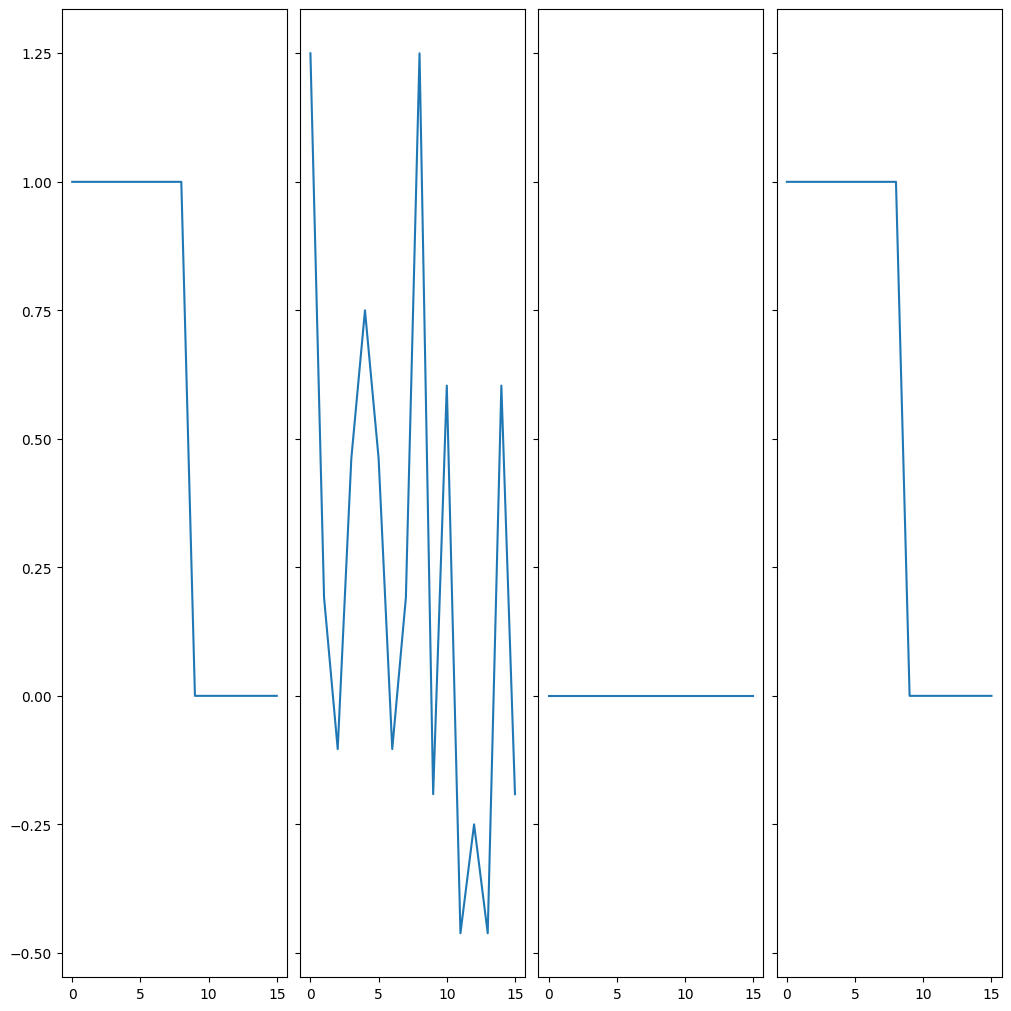

In [65]:
senal = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0])
senalModulo, senalFase = DFT_1D(senal)
## Suprimir Frecuencias Altas
senalModuloSinAltas = filtrado_frecuencias2(senalModulo,"alta")
senalSinAltas = IDFT_1D(senalModuloSinAltas,senalFase)
print(senalModuloSinAltas)

## Suprimir Frecuencias Intermedias
senalModuloSinIntermedias = filtrado_frecuencias2(senalModulo,"inter")
senalSinAltas = IDFT_1D(senalModuloSinIntermedias,senalFase)
print(senalModuloSinIntermedias)

## Suprimir Frecuencias Bajas
senalModuloSinBajas = filtrado_frecuencias2(senalModulo,"baja")
senalSinAltas = IDFT_1D(senalModuloSinBajas,senalFase)
print(senalModuloSinBajas)


fig, axes = plt.subplots(1, 4, figsize=(10, 10),sharex=True, sharey=True, layout="constrained")
axes[0].plot(range(senal.shape[0]), senal)
axes[1].plot(range(senal.shape[0]), senalSinAltas)
axes[2].plot(range(senal.shape[0]), senalModuloSinIntermedias)
axes[3].plot(range(senal.shape[0]), senalModuloSinBajas)
plt.show()


## Generar 10 imágenes y hacer la DFT y la IDFT de cada una









In [ ]:
"""
Recuerden que DFT devuelve numeros complejos, en este caso querremos devolver 2
matrices, la primera contendra la magnitud del numero en la frecuencia y la segunda
contendra su angulo
"""
def DFT_2D(imagen):
  F = np.zeros(senal.shape)
  N = senal.shape[0]
  # Realizamos el producto interno entre cada base y la senal original
  bases = []
  for k in range(N):
    for l in range(N):
      val = 0
      for n in range(N):
        for m in range(N):
          val = val + senal[n][m]*np.exp(-2*np.pi*1j*(m*k+n*l))
      val = val / N
      F[k,l] = val

  Fmagnitud = np.zeros(senal.shape)
  Fangulo = np.zeros(senal.shape)
  # Calculamas el modulo y la fase del numero complejo
  for k in range(N):
    for l in range(N):
      Fmagnitud = F[k,l]
  pass

def IDFT_2D(frecuenciasMagnitud, frecuenciasAngulo):
  pass

In [ ]:
def mostrarDFTyIDFT(imagenOriginal):
  ## Aplicar DFS a la imagen
  dfsImagenMagnitud, dfsImagenPhase = DFT_2D(imagenOriginal)
  imagenReconstruida = IDFT_2D(dfsImagenMagnitud, dfsImagenPhase)

  fig, axes = plt.subplots(2,2, figsize=(10, 10),sharex=True, sharey=True, layout="constrained")
  axes[0][0].matshow(imagenCuadradoTransladado, cmap=plt.cm.gray)
  axes[0][1].matshow(dfsImagenMagnitud, cmap=plt.cm.gray)
  axes[0][2].matshow(dfsImagenPhase, cmap=plt.cm.gray)
  axes[0][3].matshow(imagenReconstruida, cmap=plt.cm.gray)


In [ ]:
#Indicamos el tamano de la imagen
dimensionImagen = 100

#### Cuadrado transladado ####
#Creamos una imagen vacia
imagenCuadradoTransladado = np.zeros((dimensionImagen, dimensionImagen), dtype=np.uint8)
#inciamos donde iniciara el cuadrado
start = (20,40)
#Dado el tamano de los lados y su punto de inicio, nos devuelve las filas y columnas que ocupara
rr, cc = rectangle(start, extent=(20, 20))
#Pintamos esas celdas de blanco
imagenCuadradoTransladado[rr, cc] = 255

mostrarDFTyIDFT(imagenCuadradoTransladado)

#### Cuadrado transladado ####
imagenCuadradoCentral = np.zeros((dimensionImagen, dimensionImagen), dtype=np.uint8)
mostrarDFTyIDFT(imagenCuadradoCentral)

#### Rectangulo ####
imagenRectangulo = np.zeros((dimensionImagen, dimensionImagen), dtype=np.uint8)
mostrarDFTyIDFT(imagenRectangulo)

#### 2 Rectangulos ####
imagenDosRectangulo = np.zeros((dimensionImagen, dimensionImagen), dtype=np.uint8)
mostrarDFTyIDFT(imagenDosRectangulo)

#### Linea Vertical ####
imagenLineaVertical = np.zeros((dimensionImagen, dimensionImagen), dtype=np.uint8)
#indicamos el punto de inicio y el final de la linea
rr, cc = line(40, 20, 40, 90)
imagenLineaVertical[rr, cc] = 255

mostrarDFTyIDFT(imagenLineaVertical)


#### Linea 45' ####
imagenLinea45 = np.zeros((dimensionImagen, dimensionImagen), dtype=np.uint8)
mostrarDFTyIDFT(imagenLinea45)

#### Linea 90' ####
imagenLinea90 = np.zeros((dimensionImagen, dimensionImagen), dtype=np.uint8)
mostrarDFTyIDFT(imagenLinea90)

#### Varias Lineas ####
imagenVariasLineas = np.zeros((dimensionImagen, dimensionImagen), dtype=np.uint8)
mostrarDFTyIDFT(imagenVariasLineas)

#### Varias Lineas 45' ####
imagenVariasLineas45 = np.zeros((dimensionImagen, dimensionImagen), dtype=np.uint8)
mostrarDFTyIDFT(imagenVariasLineas45)

#### Varias Lineas 90' ####
imagenVariasLineas90 = np.zeros((dimensionImagen, dimensionImagen), dtype=np.uint8)
mostrarDFTyIDFT(imagenVariasLineas90)


## Hacer la Transformada de Fourier de dos imágenes dadas (I1 e I2)

1.   Visualizar el módulo y la fase de cada una
2.   Realizar IDFS utilizando el modulo de I1 y la fase de I2
3.   Realizar IDFS utilizando el modulo de I2 y la fase de I1

Analizar el aporte del módulo y la fase en cada caso

In [ ]:
imagenUnoFilename = os.path.join("/content/Imagenes", 'cameraman.jpg')
imagenUno = io.imread(imagenUnoFilename, as_gray=True)

imagenDosFilename = os.path.join("/content/Imagenes", 'einstein.jpg')
imagenDos = io.imread(imagenDosFilename, as_gray=True)

fig, axes = plt.subplots(3, 3, figsize=(10, 10))

imagenUnoModulo, imagenUnoFase = DFT_2D(imagenUno)
axes[0][0].imshow(imagenUno, cmap=plt.cm.gray)
axes[0][1].imshow(imagenUnoModulo, cmap=plt.cm.gray)
axes[0][2].imshow(imagenUnoFase, cmap=plt.cm.gray)

### COMPLETAR ###

fig.tight_layout()
plt.show()


### Componer una imagen con Cameraman y líneas horizontales (sumarlas), y remover las líneas usando la transformada de Fourier.

In [ ]:
# Abrir la imagen
# Agregan las lineas horizontales
# Realizan la transformacion de Fourier
# Analizen las funciones devueltas y piensen si pueden detectar que frecuencia estan asociadas a las lineas
# Eliminen las lineas
# Ploteen el resutado en un subplot de 3, 2. La primer fila mostrando la imagen original, las lineas por separado y la composicion
# La segunda fila mostrando la funcion el plano de modulo, fase y la imagen sin las lineas